## Assessing the Hierarchical Bayesian Tail Model

This notebook performs a quick assessment of the hierarchical tail model. To assess the performance of the HB model, I will mask/remove ZTF r-band detections of a subset of well sampled SNe. These detections will essentially be "unknown." I will then fit the model as I have done in the past on this filtered dataset without those masked points. The posterior of this fit will predict the tails of these SNe. At the specific phases where data was masked, we can compare the model prediction to the known observed fluxes at those phases we masked.

In [1]:
import numpy as np
import pandas as pd
from tailwise.hbm import TailHBModel
import arviz as az
from tailwise.plotting import plot_tail_models

# hide runtime warnings for notebook organization
import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message=r".*invalid value encountered in log10.*",
)
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message=r".*overflow encountered in dot.*",
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
m = TailHBModel()
df_clean = m.clean_data()

No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
Not enough points for fitting.
Not enough points for fitting.
Not enough points for fitting.
Not enough points for fitting.


In order to pick my subset to mask, I first do a quick calculation of each SN's coverage in the r-band.

In [4]:
df_r_band = df_clean[(df_clean['band'] == 'ZTF_r') & (df_clean['flux_mJy'].notna())].copy()

coverage = df_r_band.groupby(["oid", "sn_idx"], as_index=False).agg(
        n_points=("flux_mJy", "size"),
        phase_min=("phase", "min"),
        phase_max=("phase", "max"),
        phase_span=("phase", lambda x: x.max() - x.min()),
    )

coverage.sort_values('n_points', ascending=False).head(7)

,oid,sn_idx,n_points,phase_min,phase_max,phase_span
13,ZTF19abqrhvy,88,175,3.405058,294.471875,291.066817
1,ZTF18abjndhh,24,172,0.340544,250.030336,249.689792
37,ZTF21abouuat,77,145,1.059387,290.351030,289.291644
33,ZTF21abgilzj,103,139,4.251643,82.139526,77.887882
15,ZTF19acbwejj,33,101,0.079294,223.710046,223.630752
30,ZTF21aaqugxm,8,100,1.902778,294.033808,292.131030
10,ZTF19abajxet,26,94,2.642431,293.722535,291.080104


In [5]:
df_clean[df_clean['oid']=="ZTF19aawgxdn"].head(5)

,oid,delta_mag,band,mjd,t0,phase,flux_mJy,flux_err_mJy,lim_flux_mJy,sn_idx,band_idx,normal_sample,ls_alpha,ls_beta,ls_sigma_alpha,ls_sigma_beta,ls_chi2,ls_red_chi2
14415,ZTF19aawgxdn,-1.54,ZTF_g,58986.399155,58759.75,226.649155,0.007476,0.00226,NaN,94,0,True,-1.382516,-0.002899,0.024011,0.000193,34.810526,1.200363
14416,ZTF19aawgxdn,-1.54,ZTF_g,58764.200880,58759.75,4.450880,NaN,NaN,0.048783,94,0,True,-1.382516,-0.002899,0.024011,0.000193,34.810526,1.200363
14417,ZTF19aawgxdn,-1.54,ZTF_g,58771.111991,58759.75,11.361991,NaN,NaN,0.047066,94,0,True,-1.382516,-0.002899,0.024011,0.000193,34.810526,1.200363
14418,ZTF19aawgxdn,-1.54,ZTF_g,58771.113866,58759.75,11.363866,NaN,NaN,0.037362,94,0,True,-1.382516,-0.002899,0.024011,0.000193,34.810526,1.200363
14419,ZTF19aawgxdn,-1.54,ZTF_g,58775.115324,58759.75,15.365324,NaN,NaN,0.022507,94,0,True,-1.382516,-0.002899,0.024011,0.000193,34.810526,1.200363


I will now mask 33% of the r-band detections for these 7 test SNe. You can see that my filtered/masked dataset is smaller than the original.

In [6]:
test_oids = coverage.sort_values('n_points', ascending=False).head(7)['oid'].tolist()

def mask_detections(df, oids, frac=0.33, seed=42):
    """
    Randomly mask a fraction of detections for selected oids.
    """
    rng = np.random.default_rng(seed)

    df['masked'] = False

    for oid in oids:
        det_mask = (df["oid"] == oid) & df["flux_mJy"] & (df['band']=="ZTF_r").notna()
        det_idx = df.index[det_mask].to_numpy()
        n_det = len(det_idx)
        n_hold = int(np.ceil(frac * n_det))
        hold_idx = rng.choice(det_idx, size=n_hold, replace=False)
        df.loc[hold_idx, "masked"] = True
    return df

df_clean = mask_detections(df_clean[df_clean['flux_mJy'].notna()], test_oids)
print("Original df shape: ", df_clean.shape)
print("Masked df shape: ", df_clean[df_clean['masked']==False].shape)

Original df shape:  (3429, 19)
Masked df shape:  (3067, 19)


/tmp/ipykernel_383720/2546078145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['masked'] = False


We will of course fit the model on the filtered/masked dataset because we want to see how well it can predict those "unknown" observed fluxes.

In [8]:
masked_df = df_clean[df_clean['masked']==False]
print("Masked df shape: ", masked_df.shape)
x, y, yerr, sn_idx = m.prepare_data(filtered_df=masked_df)

Masked df shape:  (3067, 19)


In [9]:
m.build_model()
idata = m.fit_model(draws=2000, tune=3000, chains=6, cores=6, target_accept=0.99, 
                    random_seed=42, save_filename="tail_hbm_inference_for_model_assessment_0_33.nc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, sigma_int, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 2_000 draw iterations (18_000 + 12_000 draws total) took 31 seconds.


Saved inference data to /home/cal/analam/Documents/astroskills_final/data/fits/tail_hbm_inference_for_model_assessment_0_33.nc


We now have our posterior! Let's evaluate the model performance for those masked detections by doing a simple residual calculation for each masked point.

In [10]:
def evaluate_model_performance(m, df, bounds=(16, 84), include_intrinsic_scatter=False):
    """
    Evaluate the performance of the model by comparing the predicted and observed values.
    """
    rows = []
    masked_df = df[df['masked']==True].copy()

    for oid, sn in masked_df.groupby('oid'):
        phase = sn['phase'].to_numpy()
        obs_log = np.log10(sn['flux_mJy'].to_numpy())

        pred = m.predict_tail(oid, phases=phase, include_intrinsic_scatter=include_intrinsic_scatter)

        med = pred["flux_log_q50"].to_numpy()
        low = pred[f"flux_log_q{bounds[0]}"].to_numpy()
        high = pred[f"flux_log_q{bounds[1]}"].to_numpy()

        within_mask = (obs_log >= low) & (obs_log <= high)
        resid = obs_log - med

        for j in range(len(phase)):
            rows.append({
                "oid": oid,
                "phase": phase[j],
                "obs_log10F": obs_log[j],
                "pred_log10F_med": med[j],
                "pred_log10F_low": low[j],
                "pred_log10F_high": high[j],
                "resid_log10F": resid[j],
                "inside_16_84": bool(within_mask[j]),
            })

    results_df = pd.DataFrame(rows)
    
    return results_df

In [11]:
results_df = evaluate_model_performance(m, df_clean)
print("Well predicted observations: ", results_df[results_df['inside_16_84']==True].shape)
print("Poorly predicted observations: ", results_df[results_df['inside_16_84']==False].shape)
results_df.head(5)

Well predicted observations:  (32, 8)
Poorly predicted observations:  (330, 8)


,oid,phase,obs_log10F,pred_log10F_med,pred_log10F_low,pred_log10F_high,resid_log10F,inside_16_84
0,ZTF18abjndhh,2.360393,-1.752258,-1.134260,-1.146818,-1.121788,-0.617998,False
1,ZTF18abjndhh,2.362245,-1.547088,-1.134268,-1.146825,-1.121795,-0.412820,False
2,ZTF18abjndhh,4.362315,-1.546738,-1.142932,-1.155283,-1.130706,-0.403807,False
3,ZTF18abjndhh,4.363727,-1.894330,-1.142938,-1.155289,-1.130712,-0.751392,False
4,ZTF18abjndhh,6.280567,-1.692969,-1.151234,-1.163437,-1.139231,-0.541735,False


Ok this is not great... Only $\sim 8.8\%$ of the predictions are within reasonable bounds. But I didn't include intrinsic scatter in my predictive model! Without intrinsic scatter, my 16%-84% intervals will be very narrow. Intrinsic scatter is important for representing underlying variation and not heavily relying on the determined relationship (these tails are not perfectly linear). So let's give this a try with intrinsic scatter.

In [12]:
results_df = evaluate_model_performance(m, df_clean, include_intrinsic_scatter=True)
print("Well predicted observations: ", results_df[results_df['inside_16_84']==True].shape)
print("Poorly predicted observations: ", results_df[results_df['inside_16_84']==False].shape)
results_df.head(5)

Well predicted observations:  (209, 8)
Poorly predicted observations:  (153, 8)


,oid,phase,obs_log10F,pred_log10F_med,pred_log10F_low,pred_log10F_high,resid_log10F,inside_16_84
0,ZTF18abjndhh,2.360393,-1.752258,-1.135754,-1.212608,-1.055203,-0.616504,False
1,ZTF18abjndhh,2.362245,-1.547088,-1.133447,-1.214752,-1.055073,-0.413641,False
2,ZTF18abjndhh,4.362315,-1.546738,-1.144260,-1.224741,-1.063309,-0.402479,False
3,ZTF18abjndhh,4.363727,-1.894330,-1.144211,-1.224066,-1.061886,-0.750119,False
4,ZTF18abjndhh,6.280567,-1.692969,-1.152152,-1.231883,-1.071918,-0.540817,False


This is much better! Many more points fall into the 16%-84% intervals ($\sim 57.8\%$). These uncertainties are more physically motivated and our predictions are better when we consider it.

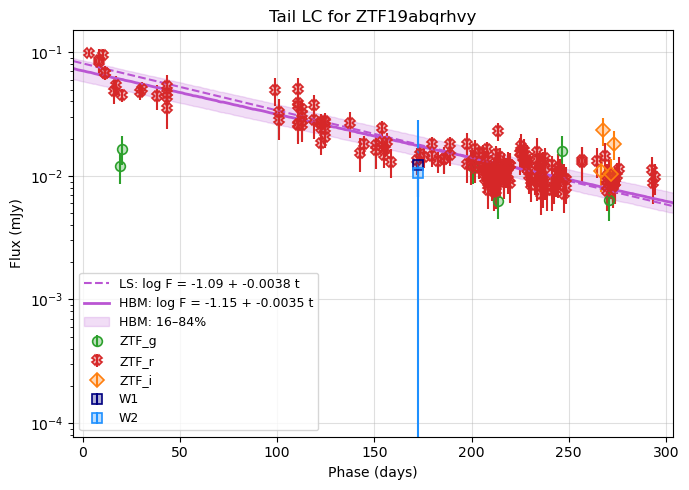

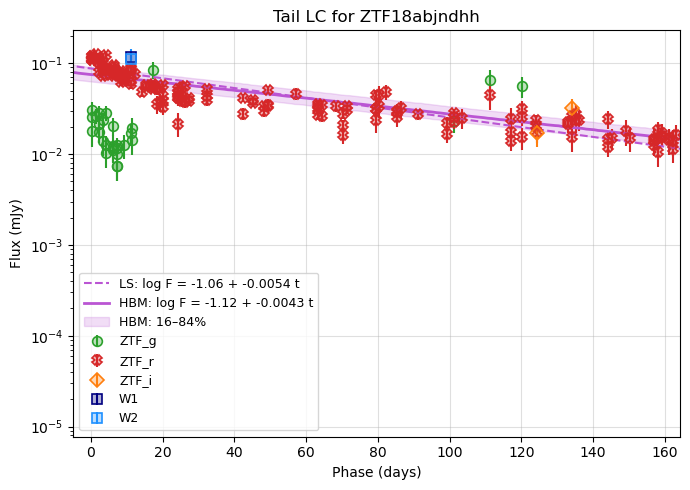

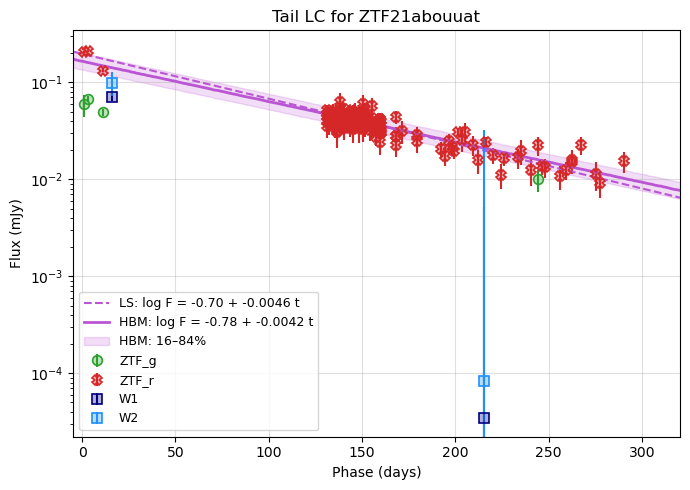

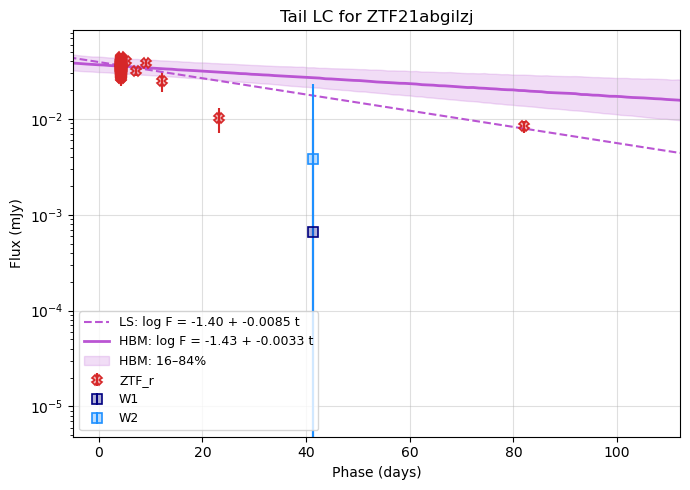

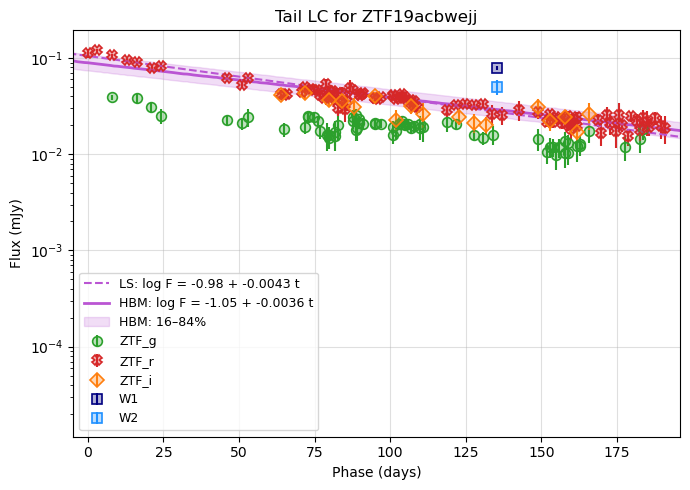

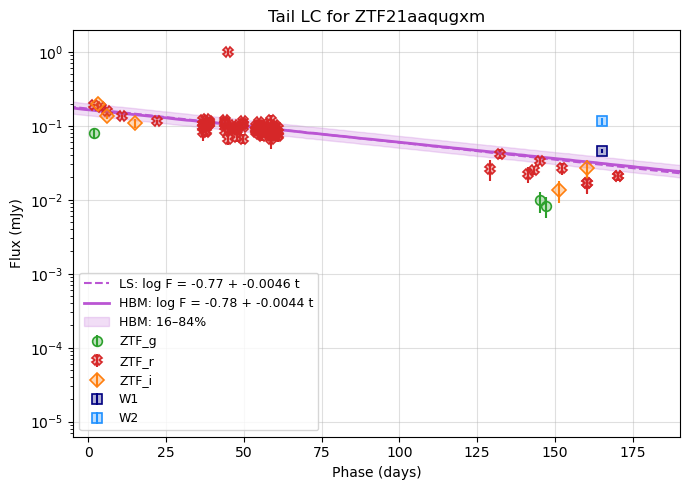

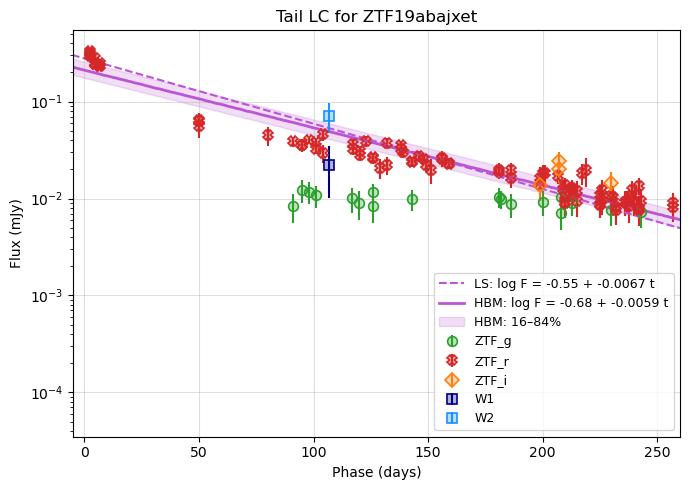

In [13]:
for i, oid in enumerate(test_oids):
    pred_df = m.predict_tail(oid, include_intrinsic_scatter=True)
    ax = plot_tail_models(oid, df_clean, pred_df)

Let's try randomly masking 50% of the detections for those test SNe.

In [14]:
m = TailHBModel()
df_clean = m.clean_data()

df_clean = mask_detections(df_clean[df_clean['flux_mJy'].notna()], test_oids, frac=0.5, seed=43)
print("Original df shape: ", df_clean.shape)
print("Masked df shape: ", df_clean[df_clean['masked']==False].shape)

No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
No data for band ZTF_i
Not enough points for fitting.
Not enough points for fitting.
Not enough points for fitting.
Not enough points for fitting.
Original df shape:  (3429, 19)
Masked df shape:  (2883, 19)


/tmp/ipykernel_383720/2546078145.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['masked'] = False


In [15]:
masked_df = df_clean[df_clean['masked']==False]
print("Masked df shape: ", masked_df.shape)
x, y, yerr, sn_idx = m.prepare_data(filtered_df=masked_df)

Masked df shape:  (2883, 19)


In [16]:
m.build_model()
idata = m.fit_model(draws=2000, tune=3000, chains=6, cores=6, target_accept=0.99, 
                    random_seed=43, save_filename="tail_hbm_inference_for_model_assessment_0_5.nc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, sigma_int, alpha, beta]


Output()

Sampling 6 chains for 3_000 tune and 2_000 draw iterations (18_000 + 12_000 draws total) took 30 seconds.


Saved inference data to /home/cal/analam/Documents/astroskills_final/data/fits/tail_hbm_inference_for_model_assessment_0_5.nc


In [17]:
results_df = evaluate_model_performance(m, df_clean, include_intrinsic_scatter=True)
print("Well predicted observations: ", results_df[results_df['inside_16_84']==True].shape)
print("Poorly predicted observations: ", results_df[results_df['inside_16_84']==False].shape)
results_df.head(5)

Well predicted observations:  (289, 8)
Poorly predicted observations:  (257, 8)


,oid,phase,obs_log10F,pred_log10F_med,pred_log10F_low,pred_log10F_high,resid_log10F,inside_16_84
0,ZTF18abjndhh,0.319688,-1.589902,-1.092110,-1.168599,-1.017726,-0.497792,False
1,ZTF18abjndhh,2.360393,-1.752258,-1.101609,-1.177649,-1.026497,-0.650649,False
2,ZTF18abjndhh,2.374861,-1.673838,-1.104015,-1.178197,-1.027345,-0.569824,False
3,ZTF18abjndhh,3.279849,-1.626397,-1.105228,-1.181032,-1.032358,-0.521169,False
4,ZTF18abjndhh,3.318032,-1.857444,-1.106231,-1.181981,-1.032467,-0.751213,False


Worse as expected! $\sim 52.9\%$